In [14]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science'])
#print(plt.rcParams.keys())
plt.rcParams['axes.labelsize'] = 11.
plt.rc('xtick',labelsize=11)
plt.rc('ytick',labelsize=11)


In [15]:
import bilby
import numpy as np

In [51]:
import bilby
import numpy as np

duration = 4.0
sampling_frequency = 1024.0

np.random.seed(88170235)

injection_parameters = dict(
    mass_1=36.0,
    mass_2=29.0,
    a_1=0.4,
    a_2=0.3,
    tilt_1=0.5,
    tilt_2=1.0,
    phi_12=1.7,
    phi_jl=0.3,
    luminosity_distance=4000.0,
    theta_jn=0.4,
    psi=2.659,
    phase=1.3,
    geocent_time=1126259642.413,
    ra=1.375,
    dec=-1.2108,
)

injection_parameters['mass_ratio'] = injection_parameters['mass_2']/injection_parameters['mass_1']
injection_parameters['chirp_mass'] = bilby.gw.conversion.component_masses_to_chirp_mass(injection_parameters['mass_1'], injection_parameters['mass_2'])

print('injection_parameters', injection_parameters)


# Fixed arguments passed into the source model
waveform_arguments = dict(
    waveform_approximant="IMRPhenomXPHM",
    reference_frequency=50.0,
    minimum_frequency=20.0,
)

# Create the waveform_generator using a LAL BinaryBlackHole source function
# the generator will convert all the parameters
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
    waveform_arguments=waveform_arguments,
)

# Set up interferometers.  In this case we'll use two interferometers
# (LIGO-Hanford (H1), LIGO-Livingston (L1). These default to their design
# sensitivity
ifos = bilby.gw.detector.InterferometerList(["H1", "L1"])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency,
    duration=duration,
    start_time=injection_parameters["geocent_time"] - 2,
)

ifos.inject_signal(
    waveform_generator=waveform_generator, parameters=injection_parameters
)


priors = bilby.gw.prior.BBHPriorDict()
priors["geocent_time"] = bilby.core.prior.Uniform(
    minimum=injection_parameters["geocent_time"]  - 0.1,
    maximum=injection_parameters["geocent_time"]  + 0.1,)


# Initialise the likelihood by passing in the interferometer data (ifos) and
# the waveoform generator, as well the priors.
# The explicit distance marginalization is turned on to improve
# convergence, and the posterior is recovered by the conversion function.
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=ifos,
    waveform_generator=waveform_generator,
    priors=priors,
)

likelihood.parameters = injection_parameters

print('Value at the truth', likelihood.log_likelihood_ratio())
injection_parameters.pop('mass_1')
injection_parameters.pop('mass_2')

15:59 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
15:59 bilby INFO    : Injected signal in H1:
15:59 bilby INFO    :   optimal SNR = 6.12
15:59 bilby INFO    :   matched filter SNR = 6.83-0.39j
15:59 bilby INFO    :   mass_1 = 36.0
15:59 bilby INFO    :   mass_2 = 29.0
15:59 bilby INFO    :   a_1 = 0.4
15:59 bilby INFO    :   a_2 = 0.3
15:59 bilby INFO    :   tilt_1 = 0.5
15:59 bilby INFO    :   tilt_2 = 1.0
15:59 bilby INFO    :   phi_12 = 1.7
15:59 bilby INFO    :   phi_jl = 0.3
15:59 bilby INFO    :   luminosity_distance = 4000.0
15:59 bilby INFO    :   theta_jn = 0.4
15:59 bilby INFO    :   psi = 2.659
15:59 bilby INFO    :   phase = 1.3
15:59 bilby INFO    :   geocent_time = 1126259642.413
15:59 bilby INFO    :   ra = 1.375
15:59 bilby INFO    :   dec = -1.2108
15:59 bilby INFO    :   m

injection_parameters {'mass_1': 36.0, 'mass_2': 29.0, 'a_1': 0.4, 'a_2': 0.3, 'tilt_1': 0.5, 'tilt_2': 1.0, 'phi_12': 1.7, 'phi_jl': 0.3, 'luminosity_distance': 4000.0, 'theta_jn': 0.4, 'psi': 2.659, 'phase': 1.3, 'geocent_time': 1126259642.413, 'ra': 1.375, 'dec': -1.2108, 'mass_ratio': 0.8055555555555556, 'chirp_mass': 28.09555579546043}
Value at the truth 32.83951195352126


29.0

In [56]:
samples = np.linspace(2500, 8500, 1000)
collect_logl = np.zeros(len(samples))



key = 'total_mass'

for ii in range(len(samples)):


    p_interest = injection_parameters.copy()
    p_interest.update({'luminosity_distance': samples[ii]})

    likelihood.parameters= p_interest

    collect_logl[ii] = likelihood.log_likelihood_ratio()



In [57]:
likelihood_values = np.exp(collect_logl)
normed_likelihood = likelihood_values/np.sum(likelihood_values)



get_dl_likelihood_samples = np.random.choice(samples, size = int(1e4), p = normed_likelihood, replace=True)
get_dl_prior_samples = bilby.gw.prior.UniformComovingVolume(samples[0], samples[-1], name = 'luminosity_distance').sample(len(get_dl_likelihood_samples))




In [58]:
dl_prior = bilby.gw.prior.UniformComovingVolume(samples[0], samples[-1], name = 'luminosity_distance')
log_prior_prob = dl_prior.ln_prob(samples)

log_posterior = collect_logl + log_prior_prob
log_posterior = log_posterior - np.max(log_posterior)

posterior_prob = np.exp(log_posterior)
posterior_prob /= np.sum(posterior_prob)

get_dl_posterior_samples = np.random.choice(samples, p = posterior_prob, replace=  True, size = len(get_dl_likelihood_samples))



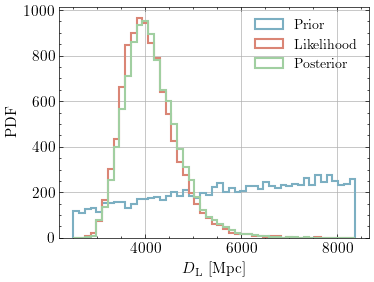

In [64]:

import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science'])
#print(plt.rcParams.keys())
plt.rcParams['axes.labelsize'] = 11.
plt.rc('xtick',labelsize=11)
plt.rc('ytick',labelsize=11)

kwargs = {'bins':np.arange(samples[0], samples[-1], 120), 'histtype':'step', 'density': 0, 'lw': 1.5}

fig, ax = plt.subplots(1, 1, figsize = (4, 3))
ax.hist(get_dl_prior_samples, **kwargs, label = 'Prior', color = '#7CAFC2')
ax.hist(get_dl_likelihood_samples, **kwargs, label = 'Likelihood', color = '#DA8575')
ax.hist(get_dl_posterior_samples, **kwargs, label = 'Posterior', color = '#A1CFA1')

ax.legend()

#ax.set_xlabel("$M_{\mathrm{total}}~[M_{\odot}]$")
ax.set_xlabel('$D_{\mathrm{L}}~{\mathrm{[Mpc]}}$')
ax.set_ylabel("PDF")
#ax.set_yscale('log')
#ax.set_ylim(0.08, 2)
ax.grid()
fig.savefig('prior_posterior.pdf')
fig.savefig('../../figures/prior_posterior.pdf')

| Color Name   | Hex       | RGB Tuple         |
| ------------ | --------- | ----------------- |
| Muted Blue   | `#7CAFC2` | `(124, 175, 194)` |
| Muted Green  | `#A1CFA1` | `(161, 207, 161)` |
| Muted Red    | `#D8A1A1` | `(216, 161, 161)` |
| Muted Purple | `#B9A1C9` | `(185, 161, 201)` |
| Muted Orange | `#E3C1A1` | `(227, 193, 161)` |
| Muted Teal   | `#A1D1C5` | `(161, 209, 197)` |
| Muted Yellow | `#E6E1A1` | `(230, 225, 161)` |
